<a href="https://colab.research.google.com/github/zouhajar/IA_EMBARQUE_2/blob/Model/model_cifar__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(" GPU détecté :", gpus)
else:
    print(" Pas de GPU détecté — CPU utilisé.")

 GPU détecté : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# ------------------------------
# Timer utilitaire
# ------------------------------
class Timer:
    def __init__(self):
        self.start = None
        self.stop = None
    def tic(self): self.start = time.time()
    def toc(self): self.stop = time.time()
    def res(self):
        return None if self.start is None or self.stop is None else self.stop - self.start


In [9]:
# ------------------------------
# Bloc MobileNet optimisé
# ------------------------------
def mobilenet_block(x, filters, stride=1, expansion=2, weight_decay=1e-4, dropout_rate=0.05):
    in_channels = x.shape[-1]
    expanded = in_channels * expansion

    if expansion != 1:
        x = layers.Conv2D(expanded, 1, padding="same", use_bias=False,
                          kernel_initializer="he_normal",
                          kernel_regularizer=regularizers.l2(weight_decay))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    x = layers.DepthwiseConv2D(3, strides=stride, padding="same", use_bias=False,
                               depthwise_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding="same", use_bias=False,
                      kernel_initializer="he_normal",
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return x


In [10]:
# Architecture compacte améliorée
# ------------------------------
def build_mobilenet_cifar10(input_shape, num_classes=10, weight_decay=1e-4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, 3, strides=1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(weight_decay))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Réseau réduit mais plus profond
    x = mobilenet_block(x, 16, stride=1, expansion=2)
    x = mobilenet_block(x, 24, stride=2, expansion=3)
    x = mobilenet_block(x, 32, stride=1, expansion=3)
    x = mobilenet_block(x, 48, stride=2, expansion=4)
    x = mobilenet_block(x, 64, stride=1, expansion=4)
    x = mobilenet_block(x, 64, stride=1, expansion=3)
    x = mobilenet_block(x, 96, stride=2, expansion=3)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="MobileNet_STM32")
    return model

In [11]:

def augment_data(x_train, y_train):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(x_train)
    return datagen

In [12]:

def load_cifar10():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test  = x_test.astype("float32") / 255.0
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test  = tf.keras.utils.to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

In [24]:

def train_model(x_train, y_train, x_val, y_val, nb_epochs=70, batch_size=64):
    model = build_mobilenet_cifar10(x_train.shape[1:])
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    lr_sched = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", factor=0.5, patience=5, min_lr=1e-5, verbose=1)

    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    datagen = augment_data(x_train, y_train)

    t = Timer(); t.tic()
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_val, y_val),
                        epochs=nb_epochs,
                        verbose=2,
                        callbacks=[lr_sched])
    t.toc()
    print(f" Entraînement terminé en {t.res():.1f}s")
    return model, history

In [23]:

def plot_history(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="train acc")
    plt.plot(history.history["val_accuracy"], label="val acc")
    plt.legend(); plt.title("Accuracy")
    plt.show()

Model: "MobileNet_STM32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 16)     │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_30 (ReLU)                 │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 32)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_31 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_14             │ (None, 32, 32, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_32 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 16)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 48)     │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32, 32, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_33 (ReLU)                 │ (None, 32, 32, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_15             │ (None, 16, 16, 48)     │           432 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 16, 16, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_34 (ReLU)                 │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 24)     │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 16, 16, 24)     │            9

 Total params: 111,410 (435.20 KB)

 Trainable params: 107,266 (419.01 KB)

 Non-trainable params: 4,144 (16.19 KB)

Epoch 1/70


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 - 81s - 103ms/step - accuracy: 0.4154 - loss: 1.8289 - val_accuracy: 0.4898 - val_loss: 1.6642 - learning_rate: 1.0000e-03
Epoch 2/70
782/782 - 33s - 42ms/step - accuracy: 0.5570 - loss: 1.4493 - val_accuracy: 0.6078 - val_loss: 1.3160 - learning_rate: 1.0000e-03
Epoch 3/70
782/782 - 31s - 40ms/step - accuracy: 0.6279 - loss: 1.2521 - val_accuracy: 0.6288 - val_loss: 1.3001 - learning_rate: 1.0000e-03
Epoch 4/70
782/782 - 42s - 53ms/step - accuracy: 0.6776 - loss: 1.1178 - val_accuracy: 0.6605 - val_loss: 1.1562 - learning_rate: 1.0000e-03
Epoch 5/70
782/782 - 31s - 39ms/step - accuracy: 0.7056 - loss: 1.0303 - val_accuracy: 0.6419 - val_loss: 1.3083 - learning_rate: 1.0000e-03
Epoch 6/70
782/782 - 31s - 40ms/step - accuracy: 0.7289 - loss: 0.9643 - val_accuracy: 0.6967 - val_loss: 1.0998 - learning_rate: 1.0000e-03
Epoch 7/70
782/782 - 31s - 40ms/step - accuracy: 0.7422 - loss: 0.9158 - val_accuracy: 0.7017 - val_loss: 1.1143 - learning_rate: 1.0000e-03
Epoch 8/70
782/782 - 31

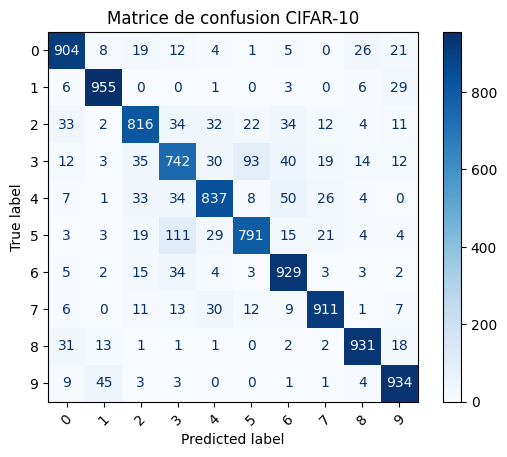

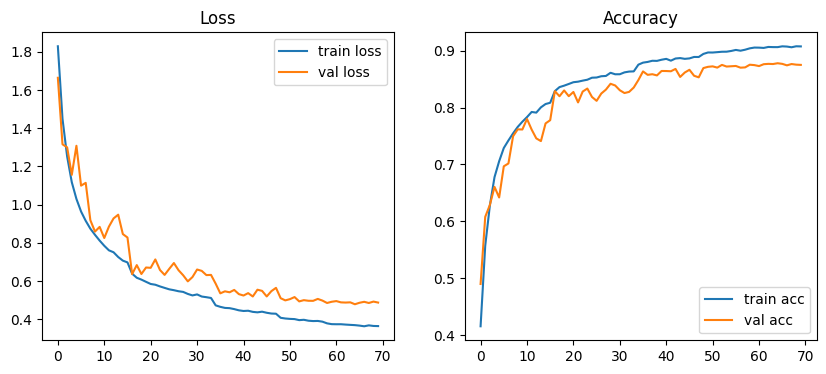

In [25]:
def test_model(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test accuracy: {acc * 100:.2f}%")

    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Matrice de confusion CIFAR-10")
    plt.show()


# Entraînement et test du modèle
model, history = train_model(
    x_train, y_train, x_test, y_test,
    nb_epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE
)

test_model(model, x_test, y_test)
plot_history(history)

# Sauvegarde des données et du modèle
np.save("CIFAR10_xtest.npy", x_test)
np.save("CIFAR10_ytest.npy", y_test)
model.save("CIFAR10_MobileNet_STM32.h5")